In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error

"""
with open('numericcols.txt', 'r') as file:
    # Read the contents of the file into a list
    lines = file.readlines()
for i in range(len(lines)):
    lines[i] = lines[i].replace('\n','').replace('.','-')
    if lines[i] == 'prop_sal_Business-central-other_support_services':
        lines[i] = 'prop_benf_paym_Business/central/other_support_services'
        
    if lines[i] == 'prop_TCURSSVC_Curr_opex_O-M_plant':
        lines[i] = 'prop_TCURSSVC_Curr_opex_O&M_plant'
    if lines[i] == 'prop_TCURSSVC_State_pay_O-M_plant_ben':
        lines[i] = 'prop_TCURSSVC_State_pay_O&M_plant_ben'
        
lines.extend(['STATE','ALL_MTH00pctprof','ALL_RLA00pctprof'])
"""

df = pd.read_csv('schooldata.csv')
df = df.drop('NCESID', axis=1)
df = df.drop('YRDATA', axis=1)
df = df.drop('Fall_membership', axis=1)

mathdf = df.drop('ALL_RLA00pctprof',axis=1)
rladf = df.drop('ALL_MTH00pctprof',axis=1)
mathdf = mathdf.dropna()
rladf = rladf.dropna()

In [2]:
mathdf['STATE'] = mathdf['STATE'].astype(str)
rladf['STATE'] = rladf['STATE'].astype(str)
mathdf_encoded = pd.get_dummies(mathdf, columns=['STATE'])
rladf_encoded = pd.get_dummies(rladf, columns=['STATE'])

In [7]:
#find best parameters (will use same params) for interpretation model and one_hot_encoding for math

X = mathdf.drop('ALL_MTH00pctprof',axis=1)
X["STATE"] = X["STATE"].astype(int)
Y = mathdf['ALL_MTH00pctprof']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
gsc = GridSearchCV(
            estimator=XGBRegressor(),
            param_grid={"learning_rate":(0.05, 0.10, 0.15,0.25,0.6,1),
                        "max_depth": [4, 5, 6, 8,10],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2,0.3],
                        "colsample_bytree":[ 0.3,0.4,0.5,0.7],},
             cv = 2, scoring='neg_mean_squared_error', verbose=2, n_jobs=7)
grid_result = gsc.fit(X_train, y_train)

Fitting 2 folds for each of 1920 candidates, totalling 3840 fits


In [11]:
import pickle as pk
#pk.dump(grid_result.best_params_, open(f'mth_best_params.pkl', 'wb'))
mth_best_params = pk.load(open('mth_best_params.pkl', 'rb'))
mth_best_params["n_estimators"] = 5000
mth_best_params["n_jobs"] = 7
mth_best_params

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 5000,
 'n_jobs': 7}

In [17]:
from IPython.display import clear_output
#train math model 
X = mathdf.drop('ALL_MTH00pctprof',axis=1)
X["STATE"] = X["STATE"].astype(int)
Y = mathdf['ALL_MTH00pctprof']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=200)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=200)

clear_output(wait=True)

xgb = XGBRegressor(**mth_best_params)
model = xgb.fit(X_train, y_train,
            eval_set = [(X_train, y_train),
                      (X_val, y_val)],verbose=100)
xgb_test_predict = model.predict(X_test)
#pk.dump(model, open(f'xgboost_math_model.pkl', 'wb'))

[0]	validation_0-rmse:55.35741	validation_1-rmse:55.40612
[100]	validation_0-rmse:8.15059	validation_1-rmse:12.61179
[200]	validation_0-rmse:6.37409	validation_1-rmse:12.34237
[300]	validation_0-rmse:5.27286	validation_1-rmse:12.24244
[400]	validation_0-rmse:4.38931	validation_1-rmse:12.17197
[500]	validation_0-rmse:3.71984	validation_1-rmse:12.11936
[600]	validation_0-rmse:3.15139	validation_1-rmse:12.08554
[700]	validation_0-rmse:2.73748	validation_1-rmse:12.06362
[800]	validation_0-rmse:2.31802	validation_1-rmse:12.04398
[900]	validation_0-rmse:1.98519	validation_1-rmse:12.02660
[1000]	validation_0-rmse:1.72954	validation_1-rmse:12.01568
[1100]	validation_0-rmse:1.48128	validation_1-rmse:12.00719
[1200]	validation_0-rmse:1.29367	validation_1-rmse:12.00013
[1300]	validation_0-rmse:1.15066	validation_1-rmse:11.99393
[1400]	validation_0-rmse:1.01740	validation_1-rmse:11.99119
[1500]	validation_0-rmse:0.87671	validation_1-rmse:11.98701
[1600]	validation_0-rmse:0.76996	validation_1-rmse:

In [18]:
print("math model training results")
print(f"root mean squared error: {(mean_squared_error(y_test, xgb_test_predict))**0.5}")

math model training results
root mean squared error: 11.983082584106029


In [21]:
from IPython.display import clear_output

#train enconded_math model

X = mathdf_encoded.drop('ALL_MTH00pctprof',axis=1)
Y = mathdf_encoded['ALL_MTH00pctprof']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=200)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=200)

clear_output(wait=True)

e_xgb = XGBRegressor(**mth_best_params)
e_model = xgb.fit(X_train, y_train,
            eval_set = [(X_train, y_train),
                      (X_val, y_val)],verbose=100)
e_xgb_test_predict = e_model.predict(X_test)
#pk.dump(e_model, open(f'xgboost_e_math_model.pkl', 'wb'))

[0]	validation_0-rmse:55.43663	validation_1-rmse:55.48566
[100]	validation_0-rmse:9.34584	validation_1-rmse:12.77128
[200]	validation_0-rmse:7.28373	validation_1-rmse:12.34101
[300]	validation_0-rmse:5.90408	validation_1-rmse:12.13833
[400]	validation_0-rmse:4.93422	validation_1-rmse:12.03642
[500]	validation_0-rmse:4.20058	validation_1-rmse:11.97732
[600]	validation_0-rmse:3.62514	validation_1-rmse:11.93941
[700]	validation_0-rmse:3.13179	validation_1-rmse:11.90831
[800]	validation_0-rmse:2.68533	validation_1-rmse:11.87904
[900]	validation_0-rmse:2.34938	validation_1-rmse:11.85822
[1000]	validation_0-rmse:2.01495	validation_1-rmse:11.84354
[1100]	validation_0-rmse:1.76681	validation_1-rmse:11.83368
[1200]	validation_0-rmse:1.55585	validation_1-rmse:11.82512
[1300]	validation_0-rmse:1.35079	validation_1-rmse:11.81834
[1400]	validation_0-rmse:1.18659	validation_1-rmse:11.81397
[1500]	validation_0-rmse:1.05093	validation_1-rmse:11.80694
[1600]	validation_0-rmse:0.91730	validation_1-rmse:

In [22]:
print("encoded math model training results")
print(f"root mean squared error: {(mean_squared_error(y_test, e_xgb_test_predict))**0.5}")

encoded math model training results
root mean squared error: 11.810992455865344


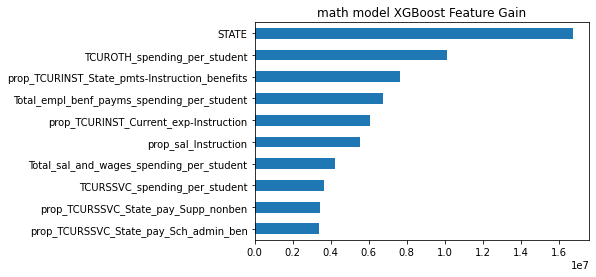

In [30]:
model = pk.load(open('xgboost_math_model.pkl', 'rb'))
x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-10:].plot(kind='barh',title="math model XGBoost Feature Gain")

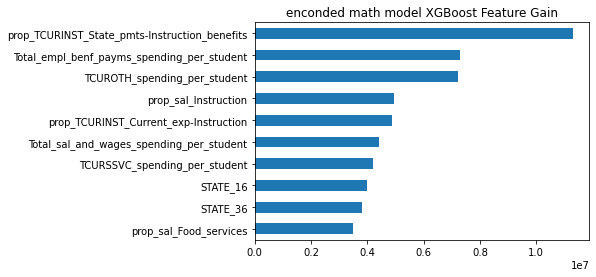

In [31]:
model = pk.load(open('xgboost_e_math_model.pkl', 'rb'))
x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-10:].plot(kind='barh',title="enconded math model XGBoost Feature Gain")

In [29]:
xgboost_math_model = pk.load(open('xgboost_math_model.pkl', 'rb'))